In [119]:
import pydicom
import parsing
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
%matplotlib inline
import csv
import pandas as pd

In [307]:
def create_dataset(csv_file_path, dicom_dir_path, contour_dir_path):
    """
    Create a map containing the dicom file name and the list of dicom files
    """
    df = pd.read_csv(csv_file_path)
    dataset = []
    for index, row in df.iterrows():
        dicom_dir = row[0]
        contour_dir = row[1]   
        dicom_dir_files = read_dicom_files(os.path.join(dicom_dir_path, dicom_dir))
        contour_dir_files = read_contour_files(os.path.join(contour_dir_path, contour_dir))
        dataset.append(create_dicom_mask_map(dicom_dir_files, contour_dir_files))
    return [item for sublist in dataset for item in sublist]
        
data = create_dataset('final_data/link.csv', 'final_data/dicoms/', 'final_data/contourfiles/')

In [308]:
def parse_files(dicom_file, contour_file):
    np_d = parse_dicom_file(dicom_file)['pixel_data']
    polys = parse_contour_file(contour_file)
    mask = poly_to_mask(polys, np_d.shape[0], np_d.shape[1])
    return np_d, mask

In [310]:
from random import choices
import numpy as np

def create_random_sample(data, epochs, sample_size):
    for e in range(epochs):
        sample = np.random.choice(data, sample_size)
        images = []
        masks = []
        for s in sample:
            for d,c in s.items():
                np_d, mask = parse_files(d, c)
                images.append(np_d)
                masks.append(mask)
        images_np = np.asarray(images)
        masks_np = np.asarray(masks)
        print(images_np.shape)
        print(masks_np.shape)
        
create_random_sample(data, 10, 8)

(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)


In [263]:
def read_dicom_files(dicom_dir):
    dicom_dir_map = {}
    #path = os.path.join('final_data/dicoms/', dicom_dir)
    dicom_dir_iterator = os.scandir(dicom_dir)
    f_names = []
    for d in dicom_dir_iterator:
        #print(parse_dicom_file(os.path.join(path, d.name)))
        #f_name = d.name.split(".")[0]
        f_names.append(os.path.abspath(d))
    return f_names

In [264]:
def read_contour_files(contour_dir):
    """
    Create a map containing the contour file name and the contour files
    """
    contour_file_names = []
    #path = os.path.join('final_data/contourfiles/', contour_dir)
    contour_dir_iterator = os.scandir(contour_dir)
    for d in contour_dir_iterator:
        if d.name == 'i-contours':
            for file in os.scandir(d):
                #contour_file_names.append(file.name.split(".")[0].split("-")[2].lstrip('0'))
                contour_file_names.append(os.path.abspath(file))
    return contour_file_names

In [274]:
def split_contour_file(x):
    head, tail = os.path.split(x)
    return tail.split(".")[0].split("-")[2].lstrip('0')

def split_dicom_file(x):
    head, tail = os.path.split(x)
    return tail.split(".")[0]

In [272]:
def create_dicom_mask_map(d_files, c_files):
    c_files_no_ext = list(map(split_contour_file, c_files))
    d_files_no_ext = list(map(split_dicom_file, d_files))
    commonalities = list(set(d_files_no_ext).intersection(c_files_no_ext))
    arr = []
    for c in commonalities:
        for x in set(c_files):
            if split_contour_file(x) == c:
                for d in d_files:
                    if split_dicom_file(d) == c:
                        arr.append({d:x})
    return arr                 

In [94]:
dicom_dir_iterator = os.scandir('final_data/dicoms/SCD0000101/')
count=0
for item in dicom_dir_iterator:
    count +=1
count

240

In [36]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = pydicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None

In [43]:
def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))

    return coords_lst

In [47]:
def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

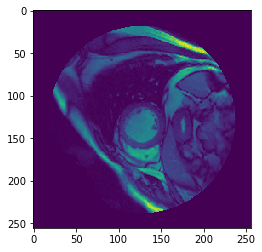

In [95]:
image = parse_dicom_file('final_data/dicoms/SCD0000101/119.dcm')['pixel_data']
plt.imshow(image)

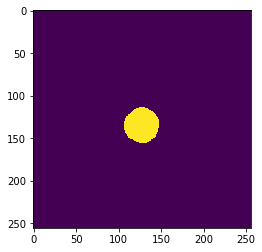

In [96]:
contours = parse_contour_file('final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0119-icontour-manual.txt')

plt.imshow(poly_to_mask(contours, image.shape[0], image.shape[1]))
